In [28]:
#normal lqr ricatti w double integrator
#from class lecture 7

using Pkg
Pkg.activate(".")

using LinearAlgebra
using ForwardDiff 
using Plots 
using SparseArrays 
using ControlSystems

  Activating project at `~/Research/log_domain_ipsolver`


In [29]:
#xk1 = xk + vk*h + 0.5*(h^2)*a
#vk1 = vk + h*ak 

#state: [xk, vk]
#control: [ak]

# Discrete dynamics
h = 0.1   # time step
A = [1 h; 0 1]
B = [0.5*h*h; h]

2-element Vector{Float64}:
 0.005000000000000001
 0.1

In [30]:
n = 2     # number of state variables
m = 1     # number of controls
Tfinal = 10.0 # final time
N = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(N-1), step=h));

In [31]:
# Initial conditions
x0 = [10.0; 0]     

2-element Vector{Float64}:
 10.0
  0.0

In [32]:
# Cost weights
Q = Array(1.0*I(2))
R = 0.1 #Array(1.0*I(1))
Qn = Array(1.0*I(2))

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

In [33]:
#Cost function
function J(xhist,uhist)
    cost = 0.5*xhist[:,end]'*Qn*xhist[:,end]
    for k = 1:(N-1)
        cost = cost + 0.5*xhist[:,k]'*Q*xhist[:,k] + 0.5*(uhist[k]'*R*uhist[k])[1]
    end
    return cost
end

J (generic function with 1 method)

In [34]:
P = zeros(n,n,N)
K = zeros(m,n,N-1)

P[:,:,N] .= Qn

#Backward Riccati recursion
for k = (N-1):-1:1
    K[:,:,k] .= (R + B'*P[:,:,k+1]*B)\(B'*P[:,:,k+1]*A)
    P[:,:,k] .= Q + A'*P[:,:,k+1]*(A-B*K[:,:,k])
end

#Forward rollout starting at x0
xhist = zeros(n,N)
xhist[:,1] = x0
uhist = zeros(m,N-1)
for k = 1:(N-1)
    uhist[:,k] .= -K[:,:,k]*xhist[:,k]
    xhist[:,k+1] .= A*xhist[:,k] + B*uhist[k]
end

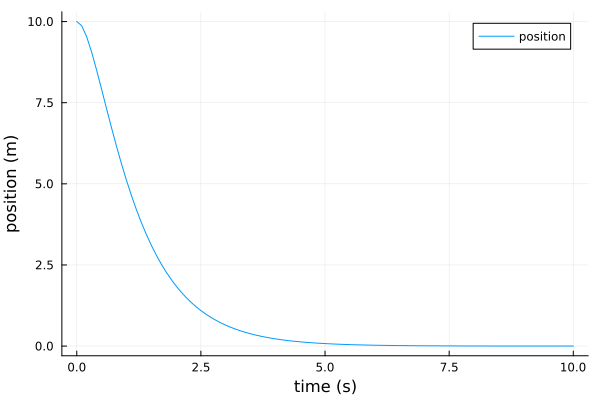

In [35]:
#position plot 
times = range(0,h*(N-1), step=h)
plot(times,xhist[1,:], label="position", xlabel="time (s)", ylabel="position (m)") 

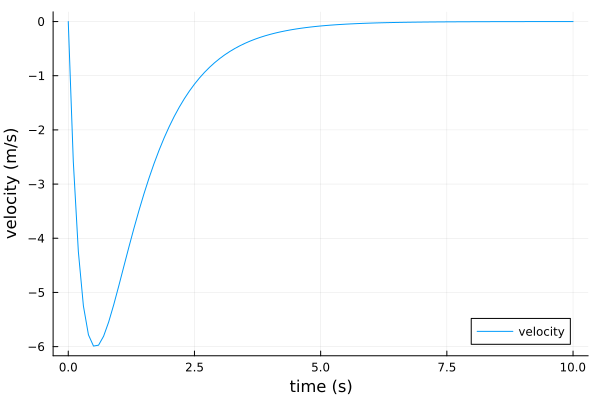

In [36]:
#velocity plot  
plot(times,xhist[2,:], label="velocity", xlabel="time (s)", ylabel="velocity (m/s)")  

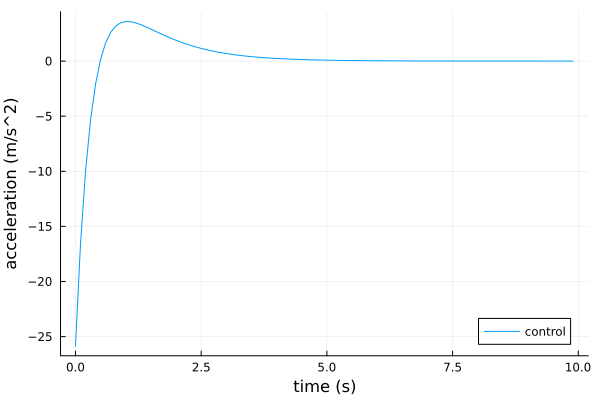

In [37]:
#controls plot 
plot(times[1:end-1], uhist[1,:], label="control", xlabel = "time (s)", ylabel= "acceleration (m/s^2)") 

In [56]:
#Forward rollout with random noise
xhist = zeros(n,N)
xhist[:,1] = x0 #10.0*randn(2) #Can start anywhere
uhist = zeros(m,N-1)
for k = 1:(N-1)
    #find the control law 
    uhist[:,k] .= -K[:,:,k]*xhist[:,k]

    xhist[:,k+1] .= A*xhist[:,k] + B*uhist[k] + 0.01*randn(2) #can add noise to dynamics
    
end

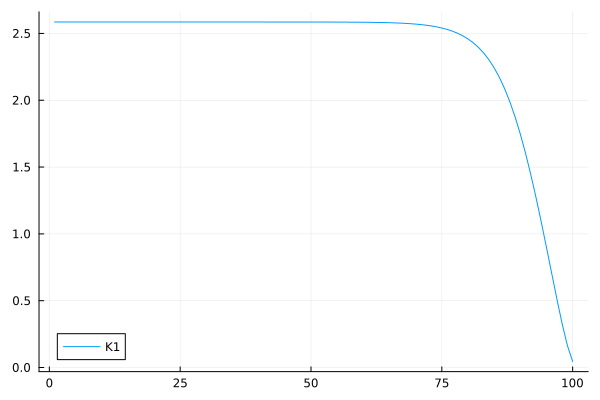

In [57]:
#the k's from ricatti converge to the infinite horizon lqr gain 
plot(K[1,1,:], label="K1")

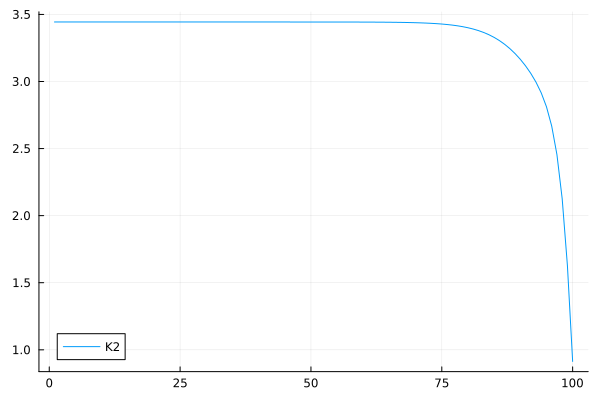

In [58]:
plot(K[1,2,:], label="K2") 

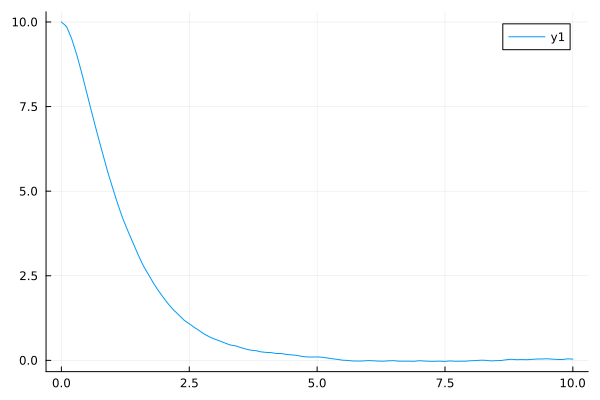

In [59]:
#position with feedback control law 
plot(times, xhist[1,:]) 

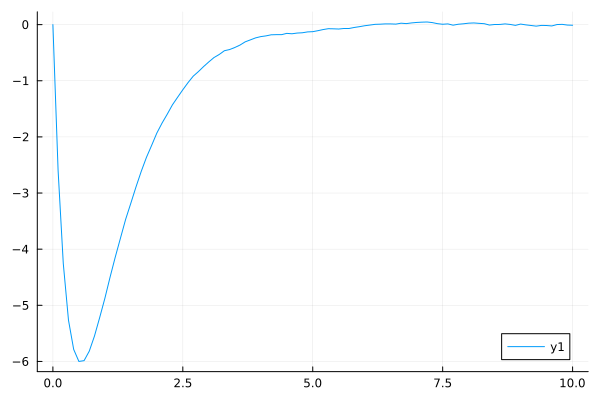

In [60]:
#velocity with feedback control law 
plot(times, xhist[2,: ]) 

In [61]:
#Compute infinite-horizon K matrix using ControlSystems.jl
Kinf = dlqr(A,B,Q,R)
#Compare to ours
K[:,:,1]-Kinf

1×2 Matrix{Float64}:
 -6.72932e-9  -2.28764e-9

In [62]:
#solve lqr problem with bound constraints 